<a href="https://colab.research.google.com/github/altaga/Open-Driving-Monitor/blob/main/Drowsiness/test/Test_Blink_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download model and images for the test

In [1]:
!wget https://github.com/altaga/Open-Driving-Monitor/raw/main/Drowsiness/model/blink-v1.pb
!wget https://github.com/altaga/Open-Driving-Monitor/raw/main/Drowsiness/model/frozen_graph.pb
!wget https://github.com/altaga/Open-Driving-Monitor/raw/main/Drowsiness/test/testImages.zip -O temp.zip
!unzip temp.zip
!rm temp.zip

--2023-11-16 00:37:31--  https://github.com/altaga/Open-Driving-Monitor/raw/main/Drowsiness/model/blink-v1.pb
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/altaga/Open-Driving-Monitor/main/Drowsiness/model/blink-v1.pb [following]
--2023-11-16 00:37:32--  https://raw.githubusercontent.com/altaga/Open-Driving-Monitor/main/Drowsiness/model/blink-v1.pb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3479143 (3.3M) [application/octet-stream]
Saving to: ‘blink-v1.pb’

blink-v1.pb         100%[===================>]   3.32M  --.-KB/s    in 0.08s   

2023-11-16 00:37:32 (42.4 MB/s) - ‘blink-v1.pb’ save

Testing all images and display the results.

{"Close": 7, "Open": 7}


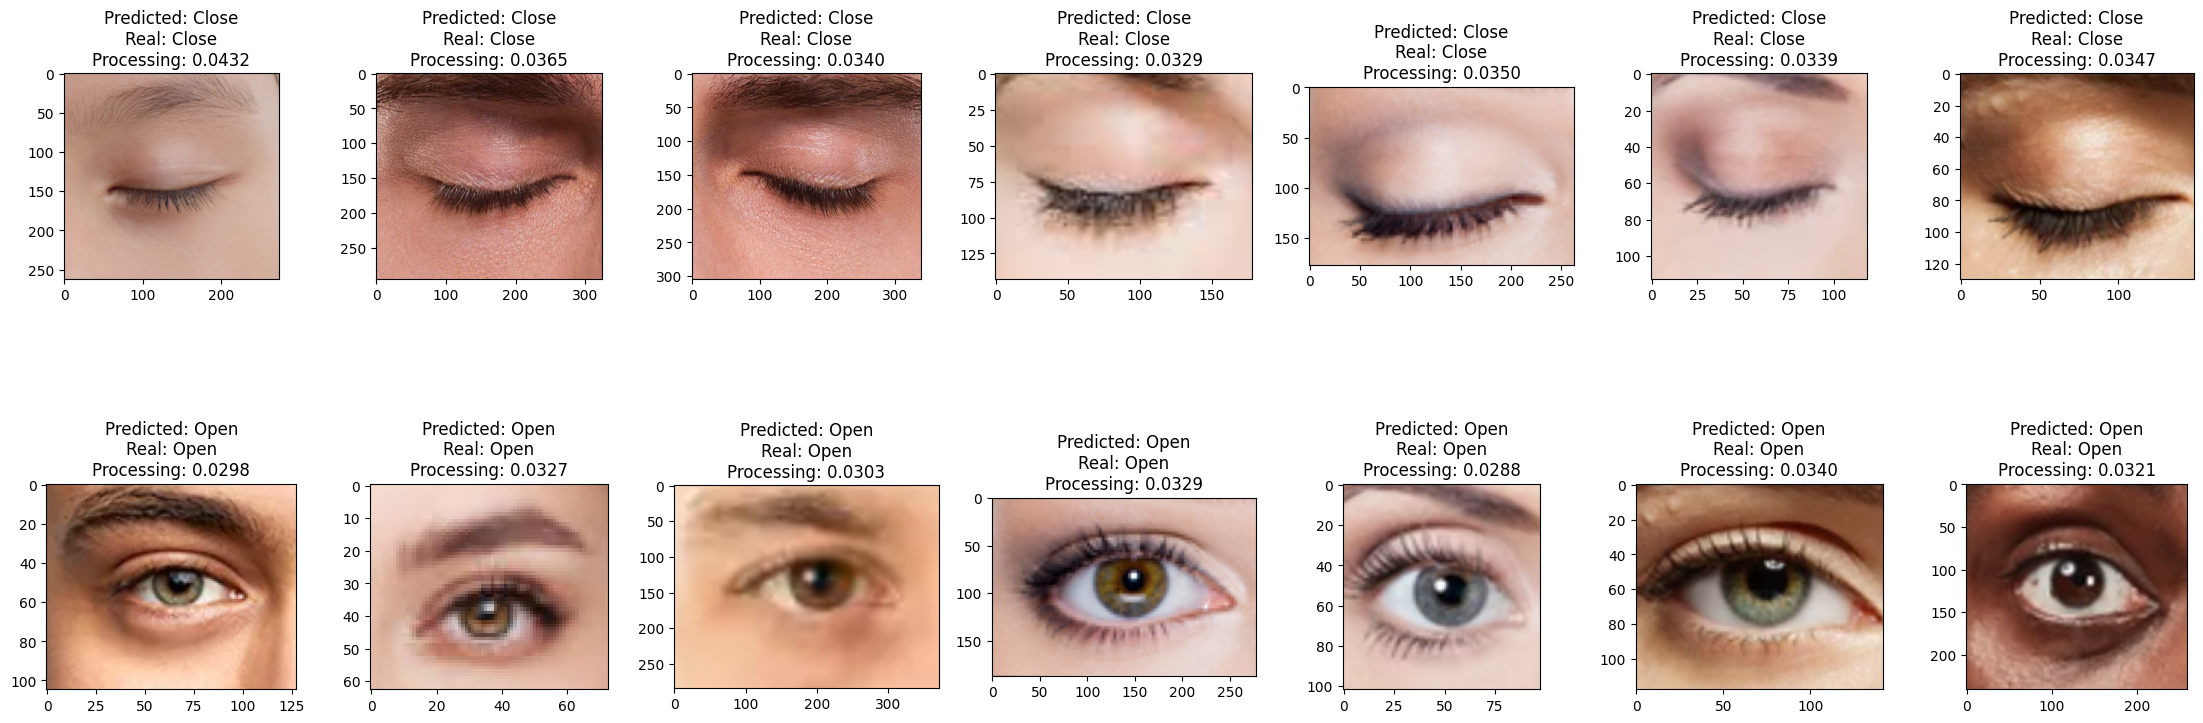

In [2]:
import cv2
import numpy as np
import time
import os
import json
from matplotlib import pyplot as plt

precisionByClass = {}
counter = 0

class_names = [ 'Close', 'Open' ]
for classes in class_names:
    precisionByClass[classes] = 0

testImages = sorted(os.listdir("testImages"))

# Plot Settings
fig = plt.figure(figsize=(7*4,2*4))


model = cv2.dnn.readNetFromTensorflow('blink-v1.pb')

# load the image from disk

i = 0
for imagePath in testImages:
    i+=1
    startReal = time.process_time()
    image = cv2.imread("testImages/"+imagePath)
    color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray3 = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    resized = cv2.resize(gray3, (24, 24),  interpolation=cv2.INTER_AREA)
    blob = cv2.dnn.blobFromImage(image=resized, scalefactor=1/256, size=(24, 24))
    model.setInput(blob)
    start = time.process_time()
    outputs = model.forward(model.getUnconnectedOutLayersNames())
    final_outputs = outputs[0][0]
    label_id = np.argmax(final_outputs)
    probs = np.exp(final_outputs) / np.sum(np.exp(final_outputs))
    final_prob = np.max(probs) * 100.
    out_name = class_names[label_id]
    if imagePath.replace(".png","")[:-1]== out_name : counter +=1
    if imagePath.replace(".png","")[:-1]== out_name : precisionByClass[out_name] +=1
    fig.add_subplot(2, 7, i)
    plt.imshow(color)
    plt.title("Predicted: {}\nReal: {}\nProcessing: {:.4f}".format(out_name, imagePath.replace(".png","")[:-1],time.process_time() - start))
    plt.subplots_adjust( hspace=1)

plt.show()

Showing a bar chart with the correct predictions and efficiency of the neural network.

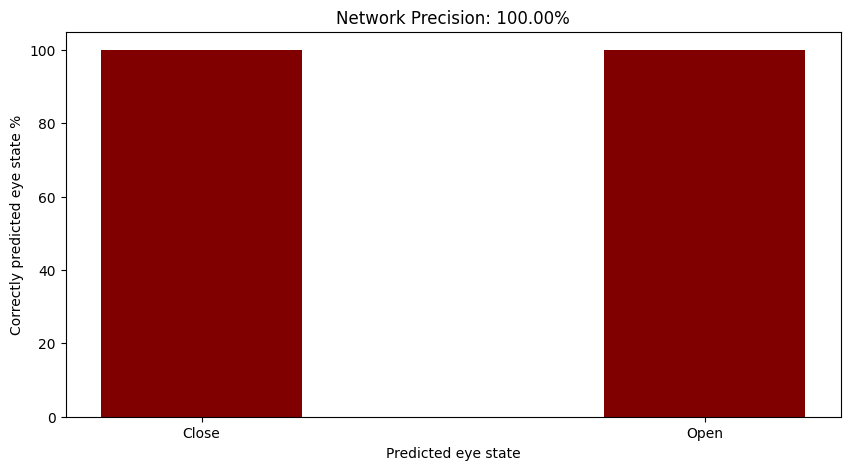

In [3]:
temp = precisionByClass
for classes in class_names:
    temp[classes] /= 7
    temp[classes] *= 100

emotions = list(temp.keys())
values = list(temp.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(emotions, values, color ='maroon',
        width = 0.4)

plt.xlabel("Predicted eye state")
plt.ylabel("Correctly predicted eye state %")
plt.title("Network Precision: {:.2f}%".format((counter/len(testImages))*100))
plt.show()